# Clustering initialization

## Imports

In [24]:
%load_ext autoreload
%autoreload 2
# This will automatically reload modules before executing code that depends on them.

from copy import deepcopy

# 3rd party imports
import numpy as np
np.set_printoptions(linewidth=1000)
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from pprint import pprint

# local imports
from modules import jacobian
from modules.data import Data
from cluster_modules import cluster, data_utils, reg_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create sample datasets

Plotted 30 point correspondences
Set 1 - X range: [50.0, 150.0], Y range: [50.3, 149.7]
Set 2 - X range: [82.8, 217.2], Y range: [51.8, 148.2]
Correspondence distances - Mean: 58.73, Std: 14.59, Max: 83.64


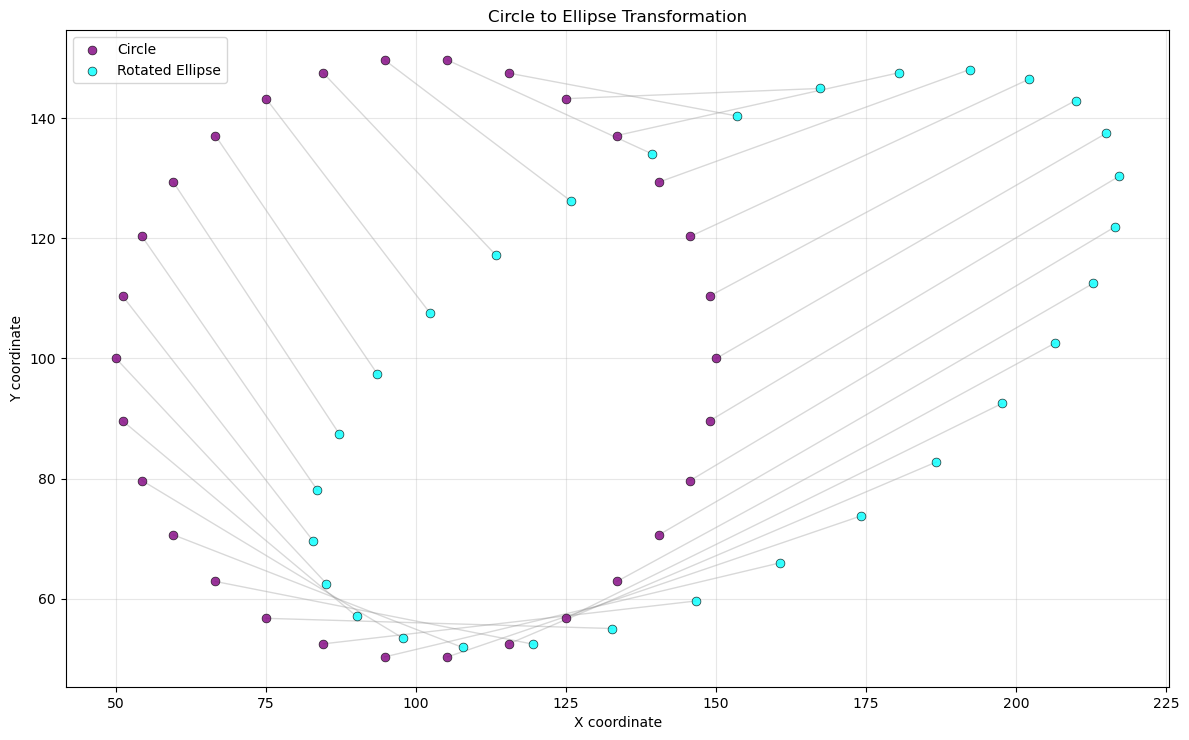

In [25]:
circle_points, ellipse_points = data_utils.circle_to_ellipse_correspondences()

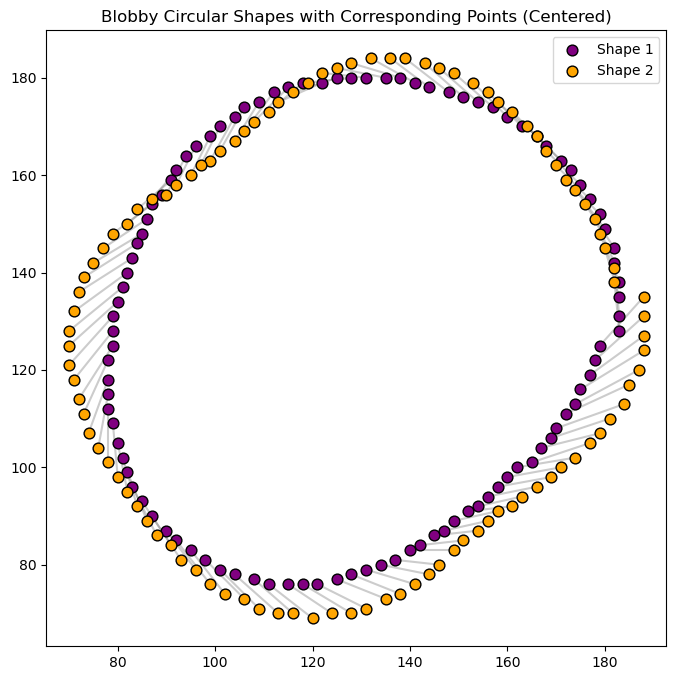

In [26]:
blob1, blob2 = data_utils.create_blobby_circular_shapes(n_points=100, plot=True, noise_scale=6)

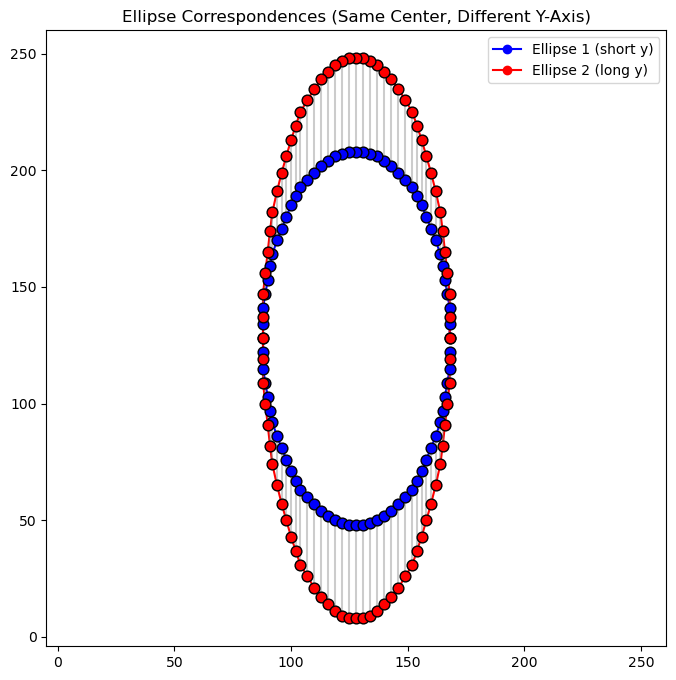

In [27]:
ellipse1, ellipse2 = data_utils.create_ellipse_correspondences(n_points=80, plot=True)

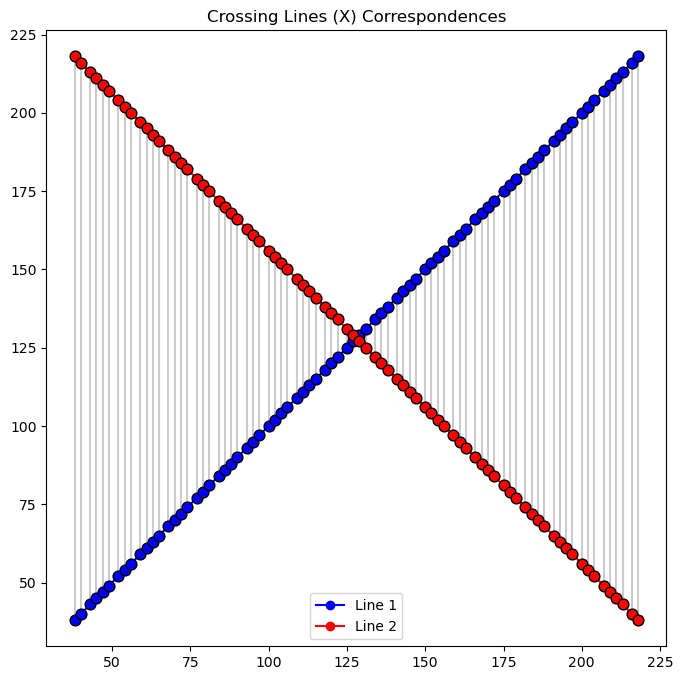

In [28]:
line1, line2 = data_utils.create_crossing_lines_correspondences(n_points=80, plot=True)

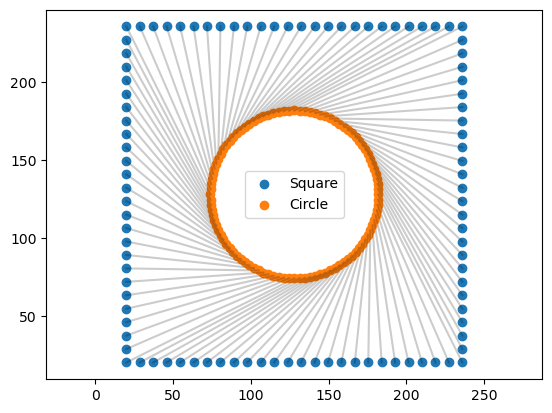

In [29]:
def square_to_circle_correspondences(n_points=100, square_size=1.0, circle_radius=1.0, resolution=(256, 256), padding=20):
    """
    Generates n_points correspondences from a square to a circle,
    mapped to a given image resolution with padding from the edges.
    Returns:
        square_points: (n_points, 2) array of (x, y) in image coordinates
        circle_points: (n_points, 2) array of (x, y) in image coordinates
    """
    # Square points: uniformly sample points along the square perimeter in CCW order starting from bottom left
    per_side = n_points // 4
    remainder = n_points % 4
    sides = [per_side] * 4
    for i in range(remainder):
        sides[i] += 1

    # Bottom (left to right)
    x0 = np.linspace(-square_size, square_size, sides[0], endpoint=False)
    y0 = np.full_like(x0, -square_size)
    # Right (bottom to top)
    y1 = np.linspace(-square_size, square_size, sides[1], endpoint=False)
    x1 = np.full_like(y1, square_size)
    # Top (right to left)
    x2 = np.linspace(square_size, -square_size, sides[2], endpoint=False)
    y2 = np.full_like(x2, square_size)
    # Left (top to bottom)
    y3 = np.linspace(square_size, -square_size, sides[3], endpoint=False)
    x3 = np.full_like(y3, -square_size)

    square_points = np.concatenate([
        np.stack([x0, y0], axis=1),
        np.stack([x1, y1], axis=1),
        np.stack([x2, y2], axis=1),
        np.stack([x3, y3], axis=1)
    ], axis=0)

    # Map each square point to a circle point by angle, starting at -pi/2 (bottom)
    angles = np.linspace(-np.pi/2, 3*np.pi/2, n_points, endpoint=False)
    circle_points = np.stack([
        circle_radius * np.cos(angles),
        circle_radius * np.sin(angles)
    ], axis=1)

    # Center both shapes in the image
    img_center = np.array(resolution) / 2

    def to_image_coords(points, obj_size):
        # Scale so that the largest shape fits within the padded area
        scale = (np.array(resolution) - 2 * padding) / (2 * max(square_size, circle_radius))
        img_points = points * scale + img_center
        return img_points

    square_img_points = to_image_coords(square_points, square_size)
    circle_img_points = to_image_coords(circle_points, circle_radius)

    return square_img_points, circle_img_points

# Usage example
square_pts, circle_pts = square_to_circle_correspondences(n_points=100, circle_radius=0.5)
plt.scatter(square_pts[:,0], square_pts[:,1], label='Square')
plt.scatter(circle_pts[:,0], circle_pts[:,1], label='Circle')
for i in range(len(square_pts)):
    plt.plot([square_pts[i,0], circle_pts[i,0]], [square_pts[i,1], circle_pts[i,1]], 'k-', alpha=0.2)
plt.legend()
plt.axis('equal')
plt.show()

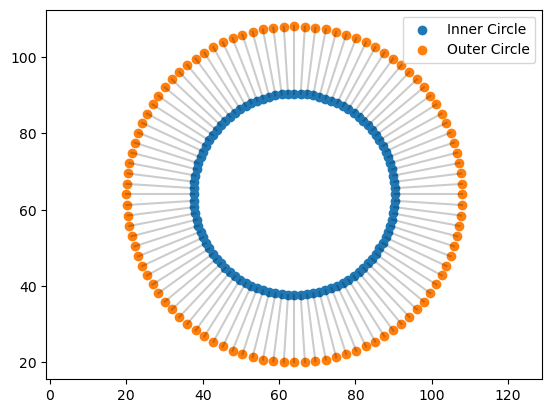

In [30]:
def circle_to_circle_correspondences(n_points=100, inner_radius=0.5, outer_radius=1.0, resolution=(256, 256), padding=20):
    """
    Generates n_points correspondences from an inner circle to an outer circle,
    mapped to a given image resolution with padding from the edges.
    Returns:
        inner_points: (n_points, 2) array of (x, y) in image coordinates
        outer_points: (n_points, 2) array of (x, y) in image coordinates
    """
    # Sample points along the perimeter, CCW starting from bottom
    angles = np.linspace(-np.pi/2, 3*np.pi/2, n_points, endpoint=False)
    inner_points = np.stack([
        inner_radius * np.cos(angles),
        inner_radius * np.sin(angles)
    ], axis=1)
    outer_points = np.stack([
        outer_radius * np.cos(angles),
        outer_radius * np.sin(angles)
    ], axis=1)

    # Center both shapes in the image
    img_center = np.array(resolution) / 2

    def to_image_coords(points, obj_size):
        # Scale so that the largest shape fits within the padded area
        scale = (np.array(resolution) - 2 * padding) / (2 * outer_radius)
        img_points = points * scale + img_center
        return img_points

    inner_img_points = to_image_coords(inner_points, inner_radius)
    outer_img_points = to_image_coords(outer_points, outer_radius)

    return inner_img_points, outer_img_points

# Usage example
inner_pts, outer_pts = circle_to_circle_correspondences(n_points=100, resolution=(128, 128), inner_radius=0.15, outer_radius=0.25)
plt.scatter(inner_pts[:,0], inner_pts[:,1], label='Inner Circle')
plt.scatter(outer_pts[:,0], outer_pts[:,1], label='Outer Circle')
for i in range(len(inner_pts)):
    plt.plot([inner_pts[i,0], outer_pts[i,0]], [inner_pts[i,1], outer_pts[i,1]], 'k-', alpha=0.2)
plt.legend()
plt.axis('equal')
plt.show()

# Correspondence density comparison

## Full double-helix

In [31]:
RUN_EXPERIMENT = False

if RUN_EXPERIMENT:
    # Create a specific double helix for correspondence analysis
    print("\n=== Creating Double Helix for Point Correspondence ===")

    resolution = (256, 256)  # Example resolution for the data
    points_to_skip = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Skip every nth point for better visualization

    #####################################################################################################

    for num_points_skip in points_to_skip:
        print(f"\n=== Resolution / {num_points_skip} ===")

        helix_wave1, helix_wave2, _ = data_utils.create_double_helix_waves(
            grid_size=256,
            num_cycles=2,
            amplitude_ratio=0.03,
            phase_offset=np.pi,  # 180 degrees for maximum separation
            padding_ratio=0.1,
            plot=False,
            horizontal=False  # Set horizontal to False for vertical helix
        )

        # Decrease point density for better visualization
        helix_wave1 = helix_wave1[::num_points_skip]  # Take every second point
        helix_wave2 = helix_wave2[::num_points_skip]  # Take every second point

        # Plot the correspondences between the two helical waves
        data_utils.plot_point_correspondences(helix_wave1, helix_wave2,
                                labels=('Moving points', 'Fixed points'),
                                colors=('red', 'blue'),
                                title=f'Double Helix Point Correspondences (resolution / {num_points_skip})',
                                show_indices=False,
                                line_alpha=0.2,  # More transparent lines to show the pattern better
                                point_size=20)

        # Swap columns to match expected format (x, y)
        helix_wave1 = helix_wave1[:, [1, 0]]  # Swap to (y, x) format
        helix_wave2 = helix_wave2[:, [1, 0]]  # Swap to (y, x) format 

        # Add 0s on the first axis to format for Data class
        helix_wave1 = np.pad(helix_wave1, ((0, 0), (1, 0)), mode='constant', constant_values=0)
        helix_wave2 = np.pad(helix_wave2, ((0, 0), (1, 0)), mode='constant', constant_values=0)

        # Run Laplacian
        d = Data(helix_wave1, helix_wave2, resolution)
        d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False,
            title=f"Double helix (point resolution / {num_points_skip})\nMin Jdet: {d.min():.2f}, Negatives: {d.count_negatives()}")

## Downwards cluster

In [32]:
if RUN_EXPERIMENT:
    # Create a specific double helix for correspondence analysis
    print("\n=== Creating Double Helix for Point Correspondence ===")

    resolution = (256, 256)  # Example resolution for the data
    points_to_skip = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Skip every nth point for better visualization

    #####################################################################################################

    for num_points_skip in points_to_skip:
        print(f"\n=== Resolution / {num_points_skip} ===")

        helix_wave1, helix_wave2, _ = data_utils.create_double_helix_waves(
            grid_size=256,
            num_cycles=2,
            amplitude_ratio=0.03,
            phase_offset=np.pi,  # 180 degrees for maximum separation
            padding_ratio=0.1,
            plot=False,
            horizontal=False  # Set horizontal to False for vertical helix
        )

        # Decrease point density for better visualization
        helix_wave1 = helix_wave1[::num_points_skip]  # Take every second point
        helix_wave2 = helix_wave2[::num_points_skip]  # Take every second point

        # Plot the correspondences between the two helical waves
        data_utils.plot_point_correspondences(helix_wave1, helix_wave2,
                                labels=('Moving points', 'Fixed points'),
                                colors=('red', 'blue'),
                                title='Double Helix Point Correspondences',
                                show_indices=False,
                                line_alpha=0.2,  # More transparent lines to show the pattern better
                                point_size=20)

        # Swap columns to match expected format (x, y)
        helix_wave1 = helix_wave1[:, [1, 0]]  # Swap to (y, x) format
        helix_wave2 = helix_wave2[:, [1, 0]]  # Swap to (y, x) format 

        # Add 0s on the first axis to format for Data class
        helix_wave1 = np.pad(helix_wave1, ((0, 0), (1, 0)), mode='constant', constant_values=0)
        helix_wave2 = np.pad(helix_wave2, ((0, 0), (1, 0)), mode='constant', constant_values=0)

        #print(f"Analyzing {len(original_moving_points)} point correspondences from double helix")
        cluster_indices, cluster_info = cluster.get_cluster_indices(helix_wave1, helix_wave2)

        # Run Laplacian
        d = Data(helix_wave1[cluster_indices[0]], helix_wave2[cluster_indices[0]], resolution)
        d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False)
        print(f"Minimum Jacobian determinant: {d.min():.2f}")
        print(f"Number of negative Jacobian determinants: {d.count_negatives()}")

## Upwards cluster

In [33]:
if RUN_EXPERIMENT:
    # Create a specific double helix for correspondence analysis
    print("\n=== Creating Double Helix for Point Correspondence ===")

    resolution = (256, 256)  # Example resolution for the data
    points_to_skip = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Skip every nth point for better visualization

    #####################################################################################################

    for num_points_skip in points_to_skip:
        print(f"\n=== Resolution / {num_points_skip} ===")

        helix_wave1, helix_wave2, _ = data_utils.create_double_helix_waves(
            grid_size=256,
            num_cycles=2,
            amplitude_ratio=0.03,
            phase_offset=np.pi,  # 180 degrees for maximum separation
            padding_ratio=0.1,
            plot=False,
            horizontal=False  # Set horizontal to False for vertical helix
        )

        # Decrease point density for better visualization
        helix_wave1 = helix_wave1[::num_points_skip]  # Take every second point
        helix_wave2 = helix_wave2[::num_points_skip]  # Take every second point

        # Plot the correspondences between the two helical waves
        data_utils.plot_point_correspondences(helix_wave1, helix_wave2,
                                labels=('Moving points', 'Fixed points'),
                                colors=('red', 'blue'),
                                title='Double Helix Point Correspondences',
                                show_indices=False,
                                line_alpha=0.2,  # More transparent lines to show the pattern better
                                point_size=20)

        # Swap columns to match expected format (x, y)
        helix_wave1 = helix_wave1[:, [1, 0]]  # Swap to (y, x) format
        helix_wave2 = helix_wave2[:, [1, 0]]  # Swap to (y, x) format 

        # Add 0s on the first axis to format for Data class
        helix_wave1 = np.pad(helix_wave1, ((0, 0), (1, 0)), mode='constant', constant_values=0)
        helix_wave2 = np.pad(helix_wave2, ((0, 0), (1, 0)), mode='constant', constant_values=0)

        #print(f"Analyzing {len(original_moving_points)} point correspondences from double helix")
        cluster_indices, cluster_info = cluster.get_cluster_indices(helix_wave1, helix_wave2)

        # Run Laplacian
        d = Data(helix_wave1[cluster_indices[1]], helix_wave2[cluster_indices[1]], resolution)
        d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False)
        print(f"Minimum Jacobian determinant: {d.min():.2f}")
        print(f"Number of negative Jacobian determinants: {d.count_negatives()}")

# Create data

## Parameters

In [34]:
resolution = (256, 256)  # Example resolution for the data
num_points_skip = 1  # Skip every 5th point for better visualization
shift_distance = 0  # Distance to shift the moving and fixed points from each other (try 100 for max distance)
cluster_method = 'y_direction'
m_data = None
f_data = None

## Full Laplacian


=== Creating Double Helix for Point Correspondence ===
Created double helix with 206 points per wave
Grid size: 256x256
Padding: 25 pixels on each side
Number of cycles: 2
Phase offset: 3.142 radians (180.0 degrees)
Wave 1 - X range: [25, 230], Y range: [120, 136]
Wave 2 - X range: [25, 230], Y range: [120, 136]
Number of intersection points: 10
Plotted 206 point correspondences
Set 1 - X range: [25.0, 230.0], Y range: [120.0, 136.0]
Set 2 - X range: [25.0, 230.0], Y range: [120.0, 136.0]
Correspondence distances - Mean: 9.79, Std: 4.83, Max: 16.00


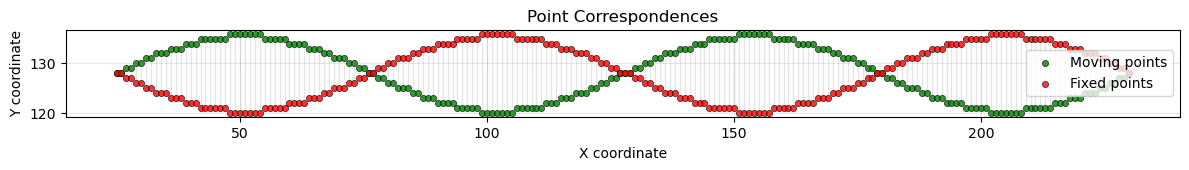

Analyzing 206 point pairs for directional clustering...
Clustering method: y_direction

Clustering Results (Y-direction (0=down, 1=up)):
Number of clusters: 2
Cluster 0: 98 points (indices: [2, 3, 4, 5, 6]...)
  Mean displacement: Z=0.000, Y=-10.286, X=0.000
  Std displacement:  Z=0.000, Y=4.408, X=0.000
Cluster 1: 108 points (indices: [0, 1, 51, 52, 53]...)
  Mean displacement: Z=0.000, Y=9.333, X=0.000
  Std displacement:  Z=0.000, Y=5.150, X=0.000
ERROR: Error getting cluster indices. Ensure the points are in the correct format and the correct method is used (y_direction or x_direction). Using half of the points as down_indices and the other half as up_indices.


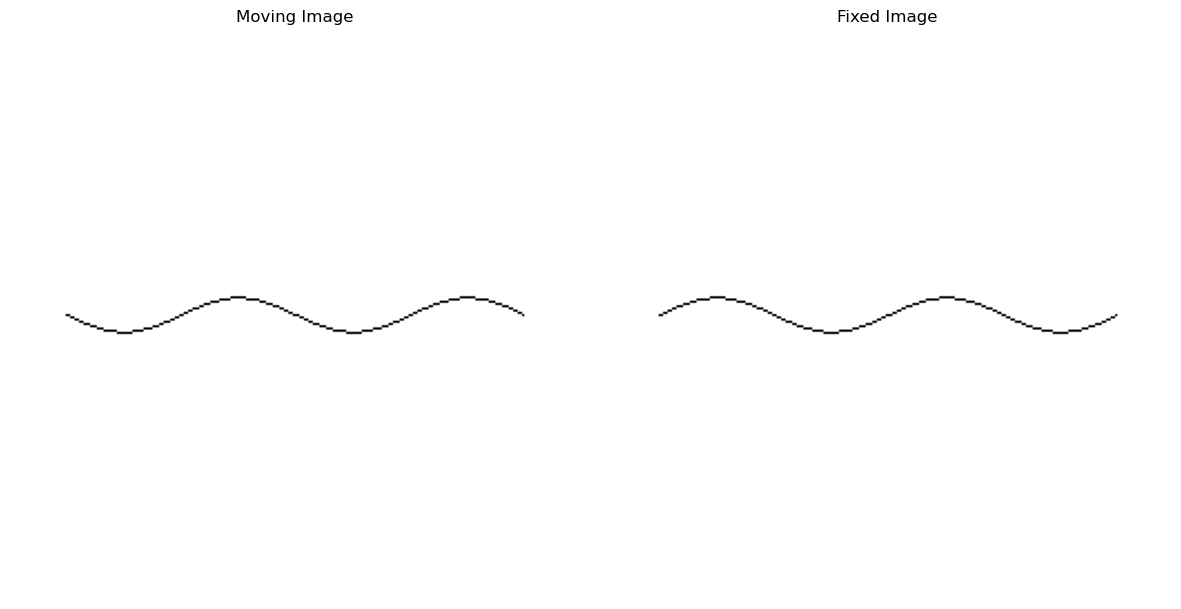

s:\GitHub\laplacian-processing\andy\jacobian\modules\laplacian.py:188: DeprecationWarning: 'scipy.sparse.linalg.lgmres' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  dx = lgmres(A, Xd, tol = 1e-2)[0]
s:\GitHub\laplacian-processing\andy\jacobian\modules\laplacian.py:188: DeprecationWarning: 'scipy.sparse.linalg.lgmres' called without specifying `atol`. This behavior is deprecated and will result in an error in SciPy v1.14.0. To preserve current behaviour, set `atol=rtol`, or, to adopt the future default, set `atol=0.0`.
  dx = lgmres(A, Xd, tol = 1e-2)[0]
s:\GitHub\laplacian-processing\andy\jacobian\modules\laplacian.py:189: DeprecationWarning: 'scipy.sparse.linalg.lgmres' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  dy = lgmres(A, Yd , tol = 1e-2)[0]
s:\GitHub\laplacian-processing\andy\jacobian\mod

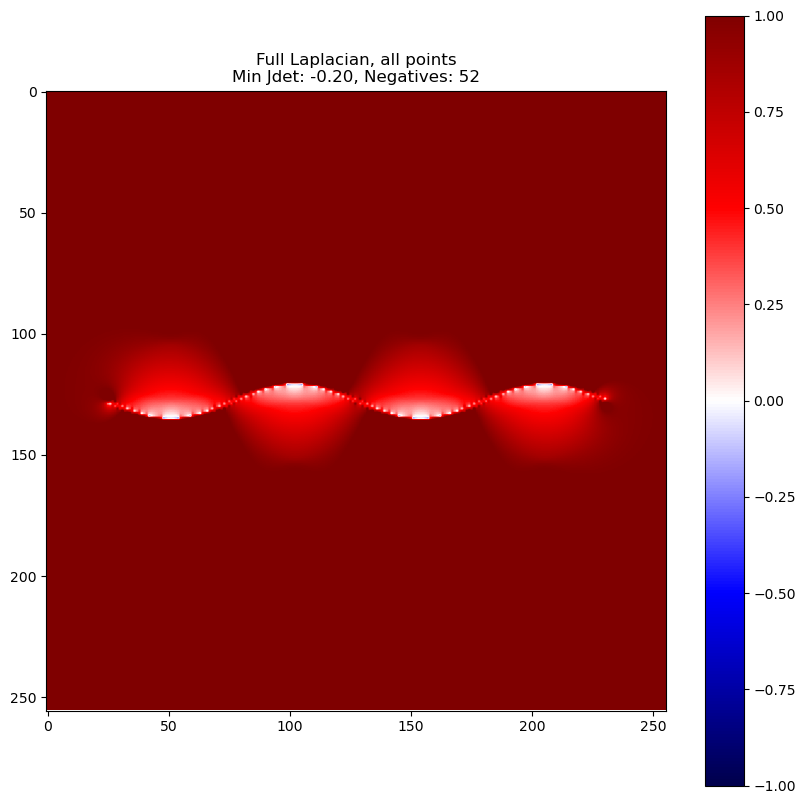

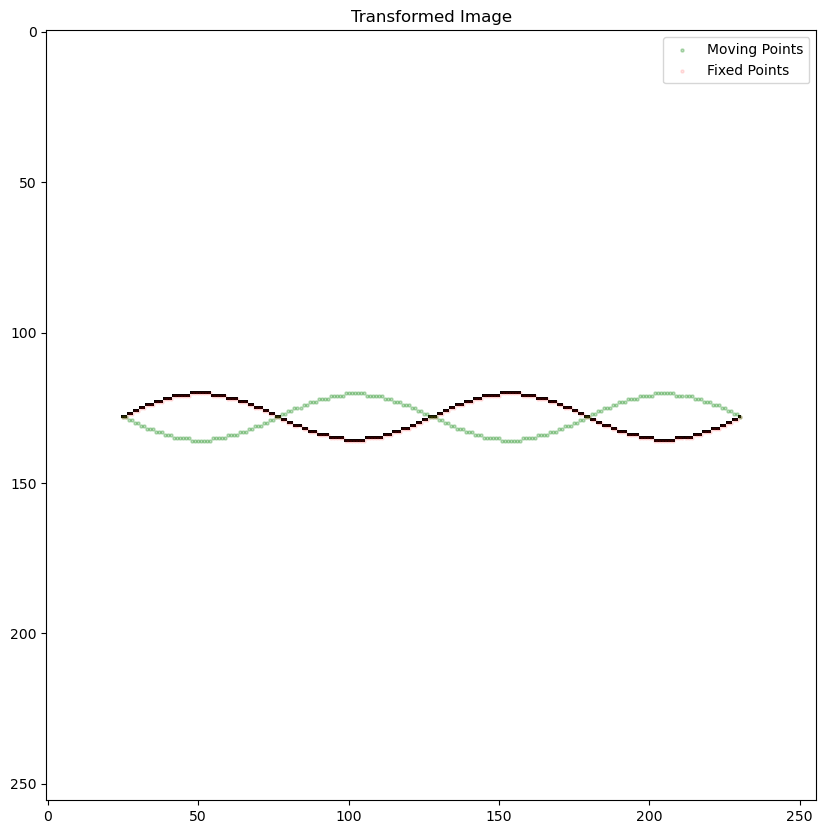

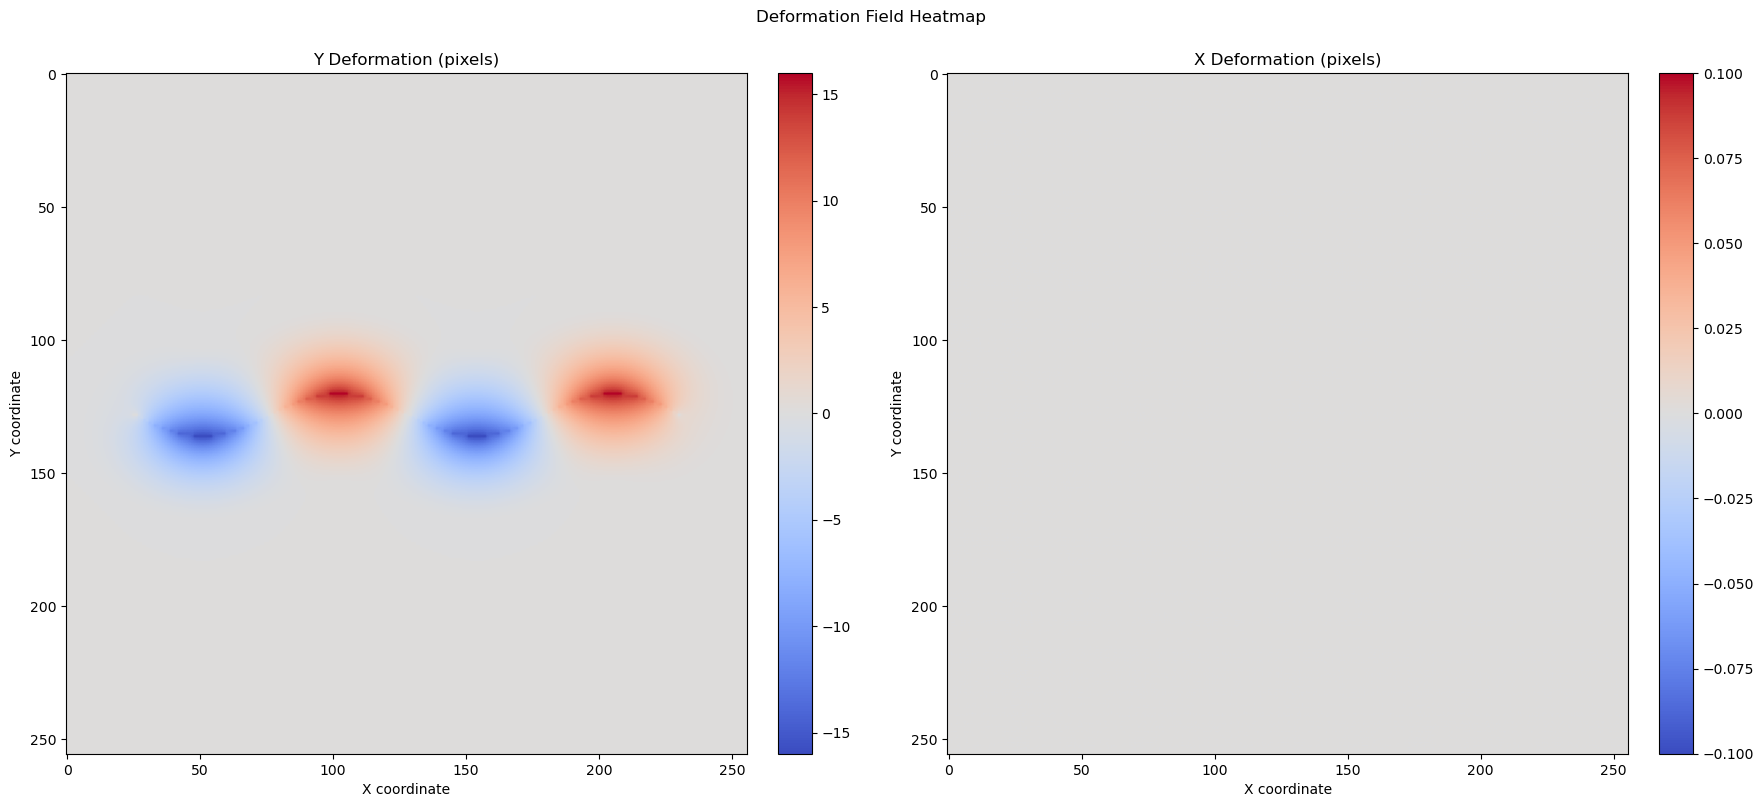

||Ax - b||: 1.51
Mean error at correspondences: 0.002190638643959975


In [35]:
#####################################################################################################
# SETUP 
#####################################################################################################

# Create a specific double helix for correspondence analysis
print("\n=== Creating Double Helix for Point Correspondence ===")
helix_wave1, helix_wave2, _ = data_utils.create_double_helix_waves(
    grid_size=min(resolution),
    num_cycles=2,
    amplitude_ratio=0.03,
    phase_offset=np.pi,  # 180 degrees for maximum separation
    padding_ratio=0.1,
    plot=False, horizontal=False,  # Set horizontal to False for vertical helix
)

# Swap with other data if provided
if m_data is not None:
    helix_wave1 = m_data
if f_data is not None:
    helix_wave2 = f_data
    
# Move helix_waves aways from each other
helix_wave1[:, 1] += -shift_distance
helix_wave2[:, 1] += shift_distance

#helix_wave1[:, 1] += 20 # y
#helix_wave1[:, 0] += 20 # x

# Decrease point density for better visualization
helix_wave1 = helix_wave1[::num_points_skip]  # Take every second point
helix_wave2 = helix_wave2[::num_points_skip]  # Take every second point

# Plot the correspondences between the two helical waves
data_utils.plot_point_correspondences(helix_wave1, helix_wave2,
                          labels=('Moving points', 'Fixed points'),
                          colors=('green', 'red'),
                          title='Point Correspondences',
                          show_indices=False,
                          line_alpha=0.2,  # More transparent lines to show the pattern better
                          point_size=20)

# Swap columns to match expected format (x, y)
helix_wave1 = helix_wave1[:, [1, 0]]  # Swap to (y, x) format
helix_wave2 = helix_wave2[:, [1, 0]]  # Swap to (y, x) format 

# Add 0s on the first axis to format for Data class
helix_wave1 = np.pad(helix_wave1, ((0, 0), (1, 0)), mode='constant', constant_values=0)
helix_wave2 = np.pad(helix_wave2, ((0, 0), (1, 0)), mode='constant', constant_values=0)

# Get the downwards and upwards clusters
try:
    cluster_indices, cluster_info = cluster.get_cluster_indices(helix_wave1, helix_wave2, method=cluster_method)
    down_indices = cluster_indices[0]
    up_indices = cluster_indices[1]
    raise Exception
except:
    print("ERROR: Error getting cluster indices. Ensure the points are in the correct format and the correct method is used (y_direction or x_direction). Using half of the points as down_indices and the other half as up_indices.")
    down_indices = [i for i in range(len(helix_wave1)//2)]
    up_indices = [i for i in range(len(helix_wave1)//2, len(helix_wave1))]

# Save to raw image
moving_img = data_utils.create_raw_image(helix_wave1, resolution, save_path="wave1.png")
fixed_img = data_utils.create_raw_image(helix_wave2, resolution, save_path="wave2.png")
data_utils.show_2_pngs(moving_img, fixed_img, title1="Moving Image", title2="Fixed Image")

#####################################################################################################
# Run Laplacian
#####################################################################################################

d = Data(helix_wave1, helix_wave2, resolution)
d_original = deepcopy(d)  # Save original data for later use

d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False, figsize=(10, 10),
       title=f"Full Laplacian, all points\nMin Jdet: {d.min():.2f}, Negatives: {d.count_negatives()}")
transformed_img = reg_utils.apply_transformation(d, moving_img, mpoints=d.mpoints, fpoints=d.fpoints, title="Transformed Image")
reg_utils.deformation_heatmap(d, title="Deformation Field Heatmap")

_, _, _, total_err = reg_utils.compute_error(d.resolution, helix_wave1, helix_wave2, d.deformation)
print(f"||Ax - b||: {total_err:.2f}")
errors = reg_utils.correspondence_error(d.deformation, helix_wave1, helix_wave2)
print("Mean error at correspondences:", np.mean(errors))
#rint("Max error at correspondences:", np.max(errors))

In [36]:
np.save("d_moving.npy", d)

In [13]:
#down_indices_copy = deepcopy(down_indices)
#up_indices_copy = deepcopy(up_indices)
#down_indices = down_indices_copy
#up_indices = up_indices_copy

## Run on individual clusters

In [14]:
RUN_EXPERIMENT = False
if RUN_EXPERIMENT:
        # Run Laplacian on down indices
        d = Data(helix_wave1[down_indices], helix_wave2[down_indices], resolution)
        d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False, binarize_negatives=False, figsize=(10, 10),
                title="Down Cluster\nMin Jdet: {:.2f}, Negatives: {}".format(d.min(), d.count_negatives()))
        _ = reg_utils.apply_transformation(d, moving_img, mpoints=d.mpoints, fpoints=d.fpoints, title="Transformed Moving Image (Down cluster)")
        _, _, _, total_err = reg_utils.compute_error(d.resolution, helix_wave1[down_indices], helix_wave2[down_indices], d.deformation)
        print(f"Down cluster error: {total_err:.2f}")

        # Run Laplacian on up indices
        d = Data(helix_wave1[up_indices], helix_wave2[up_indices], resolution)
        d.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False, binarize_negatives=False, figsize=(10, 10),
                title=f"Up Cluster\nMin Jdet: {d.min():.2f}, Negatives: {d.count_negatives()}")
        _ = reg_utils.apply_transformation(d, moving_img, mpoints=d.mpoints, fpoints=d.fpoints, title="Transformed Moving Image (Up cluster)")
        _, _, _, total_err = reg_utils.compute_error(d.resolution, helix_wave1[up_indices], helix_wave2[up_indices], d.deformation)
        print(f"Up cluster error: {total_err:.2f}")

## Laplacian clustering

In [15]:
def cluster_laplacian(moving_points, fixed_points, resolution, clusters, moving_img=None, verbose=True):
    """
    Apply manual cluster-wise deformation as in the 'Down first' block.
    Args:
        moving_points: np.ndarray, shape (N, 3)
        fixed_points: np.ndarray, shape (N, 3)
        resolution: tuple, image resolution
        clusters: list of lists/arrays, each contains indices for a cluster
        moving_img: optional, image for visualization
        verbose: bool, show plots and info
    Returns:
        d_combined: Data object with combined deformation
    """
    # Step 1: First cluster deformation
    cluster1_idx = clusters[0]
    cluster2_idx = clusters[1]
    d1 = Data(moving_points[cluster1_idx], fixed_points[cluster1_idx], resolution)
    if verbose:
        d1.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False,
                binarize_negatives=False, title=f"Cluster 1\nMin Jdet: {d1.min():.2f}, Negatives: {d1.count_negatives()}")
    if moving_img is not None:
        iter1 = reg_utils.apply_transformation(d1, moving_img, mpoints=moving_points, fpoints=fixed_points,
                                    title="Transformed Moving Image (Cluster 1)")
    else:
        iter1 = None

    # Step 2: Fix cluster 1 points, move cluster 2 points
    new_mpoints = moving_points.copy()
    new_fpoints = fixed_points.copy()
    new_mpoints[cluster1_idx] = new_fpoints[cluster1_idx]  # Fix moving points to fixed points

    for idx in cluster2_idx:
        curr_mcoord = moving_points[idx]
        curr_fcoord = fixed_points[idx]
        
        #curr_mcoord = np.round(curr_mcoord).astype(int)
        #curr_fcoord = np.round(curr_fcoord).astype(int)
        
        new_mdisplacement = d1.deformation[:, 0, np.round(curr_mcoord[1]).astype(int), np.round(curr_mcoord[2]).astype(int)]
        new_fdisplacement = d1.deformation[:, 0, np.round(curr_fcoord[1]).astype(int), np.round(curr_fcoord[2]).astype(int)]
        # Optionally use new_fdisplacement, but original code uses new_mdisplacement for both
        new_mcoord = curr_mcoord + new_mdisplacement
        new_mcoord = np.round(new_mcoord).astype(int)
        #new_fcoord = curr_fcoord + new_mdisplacement
        new_fcoord = curr_fcoord + new_fdisplacement  # Use same displacement for fixed points
        new_fcoord = np.round(new_fcoord).astype(int)
        new_mpoints[idx] = new_mcoord
        new_fpoints[idx] = new_fcoord

    # Step 4: New Data object with updated points
    d2 = Data(new_mpoints, new_fpoints, resolution)
    if verbose:
        d2.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False,
                binarize_negatives=False, title=f"Cluster 2\nMin Jdet: {d2.min():.2f}, Negatives: {d2.count_negatives()}")
    if moving_img is not None and iter1 is not None:
        iter2_reg = reg_utils.apply_transformation(d2, iter1, mpoints=moving_points, fpoints=fixed_points,
                                                   title="Transformed Moving Image (Cluster 2)")

    # Step 5: Combine deformation fields
    d_combined = Data(moving_points, fixed_points, resolution)
    d_combined.deformation = cluster.compose_deformation_fields(d1.deformation, d2.deformation)
    d_combined.jdet_field = jacobian.sitk_jacobian_determinant(d_combined.deformation)[0]
    if verbose:
        d_combined.show(fontsize=0, show_text=False, show_axis=False, show_correspondence=False, show_orientation=False,
                        title=f"Combined Deformation\nMin Jdet: {d_combined.min():.2f}, Negatives: {d_combined.count_negatives()}")
    if moving_img is not None:
        composed_reg = reg_utils.apply_transformation(d_combined, moving_img, mpoints=moving_points, fpoints=fixed_points,
                            title="Transformed Moving Image (Composed Deformation)")
        print("L2 difference between iteration 2 and composed deformation:", np.linalg.norm(iter2_reg - composed_reg))

    return d_combined



In [16]:
print(up_indices)
print(down_indices)

[103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102]


In [17]:
# Get coordinates where 
d_original.get_negative_coordinates()

Negative Jacobian determinants:
(121, 99)
(121, 100)
(121, 101)
(121, 102)
(121, 103)
(121, 104)
(121, 105)
(121, 202)
(121, 203)
(121, 204)
(121, 205)
(121, 206)
(121, 207)
(121, 208)
(122, 94)
(122, 110)
(122, 111)
(122, 197)
(122, 213)
(122, 214)
(123, 90)
(123, 114)
(123, 193)
(123, 217)
(124, 87)
(124, 190)
(132, 66)
(132, 169)
(133, 39)
(133, 63)
(133, 142)
(133, 166)
(134, 42)
(134, 43)
(134, 59)
(134, 145)
(134, 146)
(134, 162)
(135, 48)
(135, 49)
(135, 50)
(135, 51)
(135, 52)
(135, 53)
(135, 54)
(135, 151)
(135, 152)
(135, 153)
(135, 154)
(135, 155)
(135, 156)
(135, 157)


array([[121,  99],
       [121, 100],
       [121, 101],
       [121, 102],
       [121, 103],
       [121, 104],
       [121, 105],
       [121, 202],
       [121, 203],
       [121, 204],
       [121, 205],
       [121, 206],
       [121, 207],
       [121, 208],
       [122,  94],
       [122, 110],
       [122, 111],
       [122, 197],
       [122, 213],
       [122, 214],
       [123,  90],
       [123, 114],
       [123, 193],
       [123, 217],
       [124,  87],
       [124, 190],
       [132,  66],
       [132, 169],
       [133,  39],
       [133,  63],
       [133, 142],
       [133, 166],
       [134,  42],
       [134,  43],
       [134,  59],
       [134, 145],
       [134, 146],
       [134, 162],
       [135,  48],
       [135,  49],
       [135,  50],
       [135,  51],
       [135,  52],
       [135,  53],
       [135,  54],
       [135, 151],
       [135, 152],
       [135, 153],
       [135, 154],
       [135, 155],
       [135, 156],
       [135, 157]], dtype=int64

In [18]:
pt = (120, 206)
current_jdet = d_original.jdet_field[pt[0], pt[1]]
current = d_original.deformation[:, 0, pt[0], pt[1]]
down = d_original.deformation[:, 0, pt[0]-1, pt[1]]
up = d_original.deformation[:, 0, pt[0]+1, pt[1]]
left = d_original.deformation[:, 0, pt[0], pt[1]-1]
right = d_original.deformation[:, 0, pt[0], pt[1]+1]

print("Mapping in moving space:")
print("Current point:", pt)
print("Jdet:", current_jdet)

print("Current:", current)
print("Down:", down)
print("Up:", up)
print("Left:", left)
print("Right:", right)

((down - up) / 2) - (right - left) / 2

Mapping in moving space:
Current point: (120, 206)
Jdet: 1.1186433943386698
Current: [ 0.         15.99641848  0.        ]
Down: [ 0.        14.6705409  0.       ]
Up: [ 0.         14.90782769  0.        ]
Left: [ 0.         15.99641848  0.        ]
Right: [ 0.         15.99641848  0.        ]


array([ 0.        , -0.11864339,  0.        ])

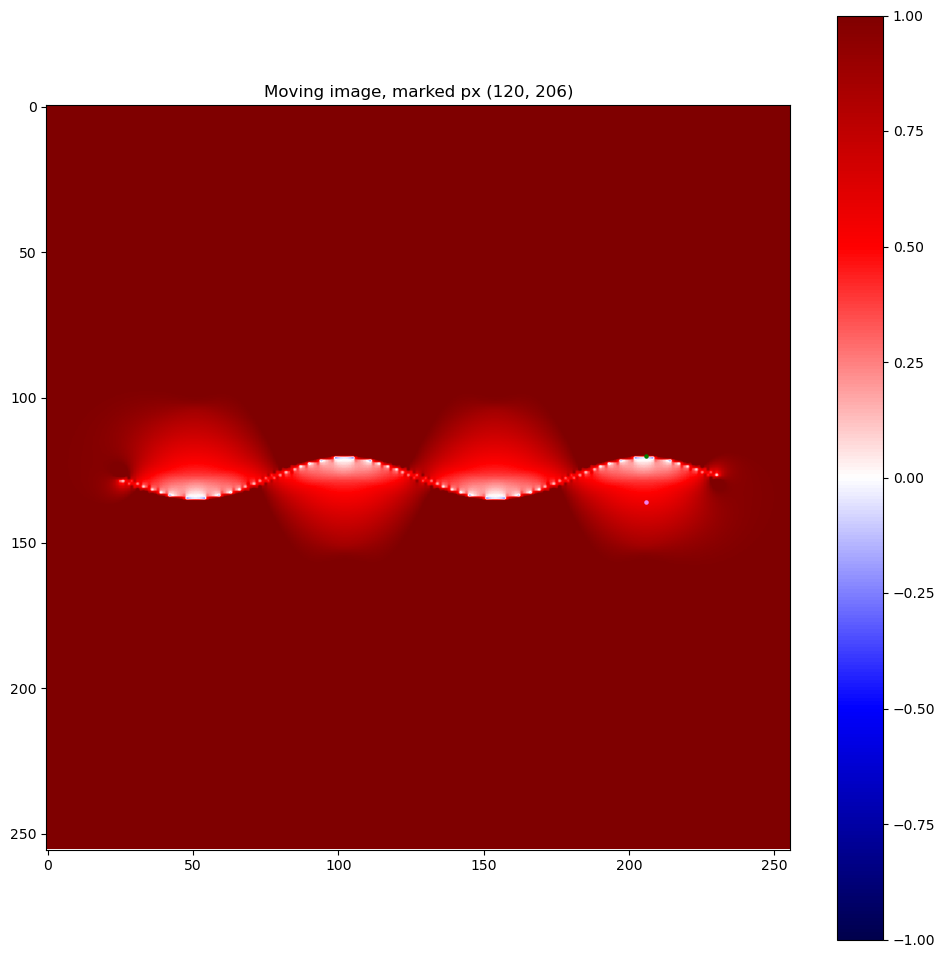

In [19]:
def show(d, px, figsize: tuple = (10, 5), fontsize: int = 6, show_text=True, show_axis=True, show_correspondence=True, show_orientation=False, binarize_negatives=False):
    """Show the deformation field and the Jacobian determinant field.
    
    Args:
        title (str, optional): Title of the plot. Defaults to None.
        figsize (tuple, optional): Size of the plot. Defaults to (10, 5).
        fontsize (int, optional): Font size of the text. Defaults to 6.
        show_text (bool, optional): Whether to show text on the plot. Defaults to True.
        show_axis (bool, optional): Whether to show the normalized axis text or use the default. Defaults to True.
    """
    #norm = mcolors.TwoSlopeNorm(vmin=min(self.jdet_field.min(), -1), vcenter=0, vmax=self.jdet_field.max())
    norm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
    
    jdet_field = d.jdet_field.copy()
    
    #if binarize_negatives:
    #    jdet_field[jdet_field < 0] = -1
    #    jdet_field[jdet_field > 0] = 1  # Clip values to [-1, 1] for better visualization

    f = plt.figure(figsize=figsize)
    plt.imshow(jdet_field, cmap="seismic", norm=norm)
    plt.colorbar()
    
    plt.scatter(px[1], px[0], c='green', s=5)
    plt.scatter(px[1] + d.deformation[2, 0, px[0], px[1]], px[0] + d.deformation[1, 0, px[0], px[1]], c='violet', s=5)
    plt.title(f"Moving image, marked px {px}")
    plt.show()
    f.clear()
    plt.close(f)
    
show(d, px=pt, figsize=(12, 12))

In [20]:
# Find the index of the row in an array where the values match (0, 120, 206)
def find_index(arr, values):
    """
    arr: np.ndarray of shape (N, 3)
    values: tuple or list of 3 values to match
    Returns: index or -1 if not found
    """
    matches = np.where(np.all(arr == values, axis=1))[0]
    return matches[0] if len(matches) > 0 else -1

# Example usage:
idx = find_index(helix_wave1, (0, 120, 206))
print("Index of (0, 120, 206):", idx)

print(helix_wave1[181])
print(helix_wave2[181])

#print(helix_wave1)

Index of (0, 120, 206): 181
[  0 120 206]
[  0 136 206]


### Down first

Down indices then up indices


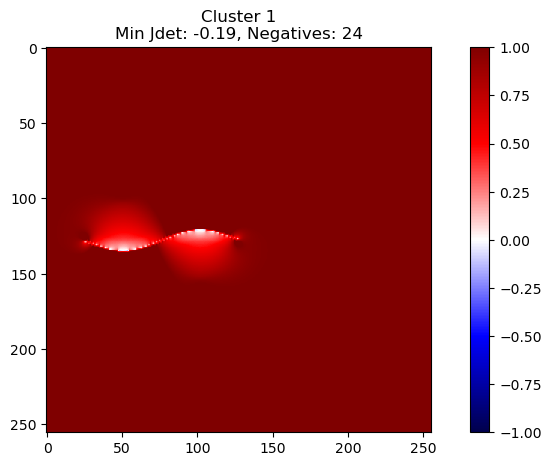

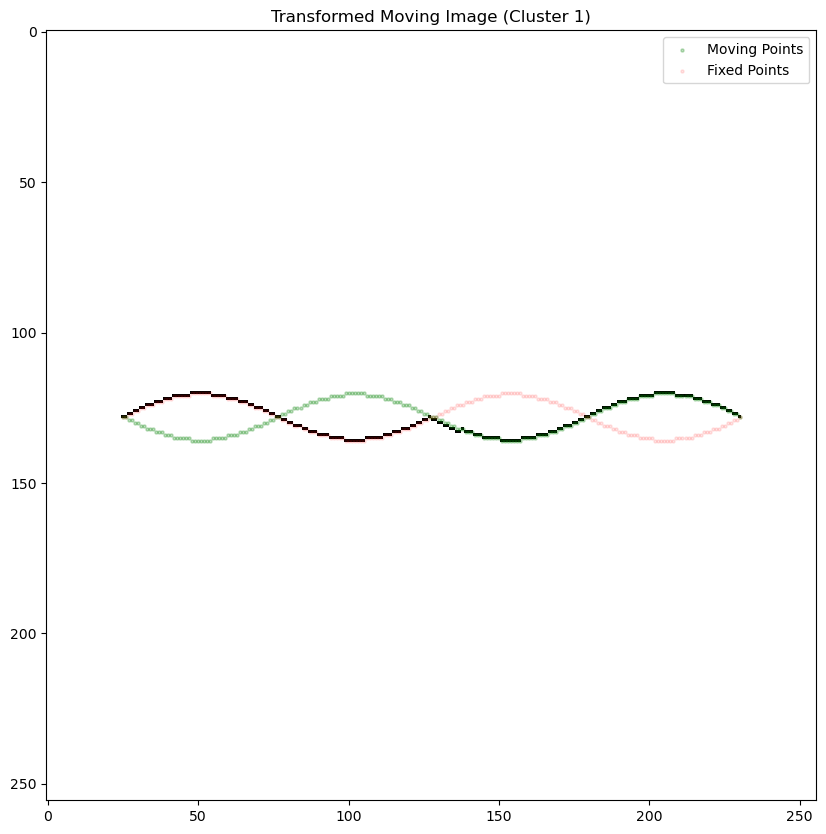

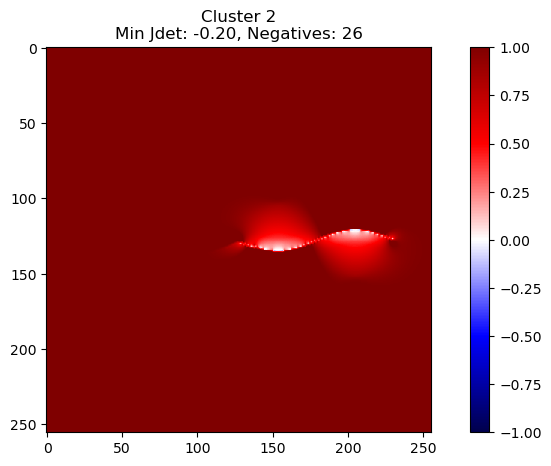

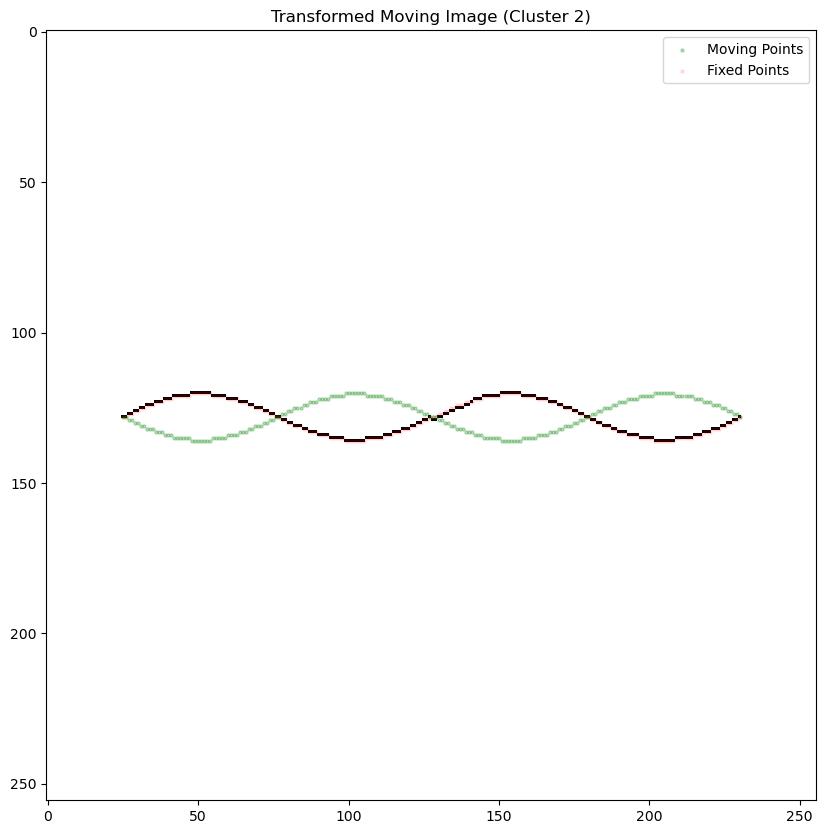

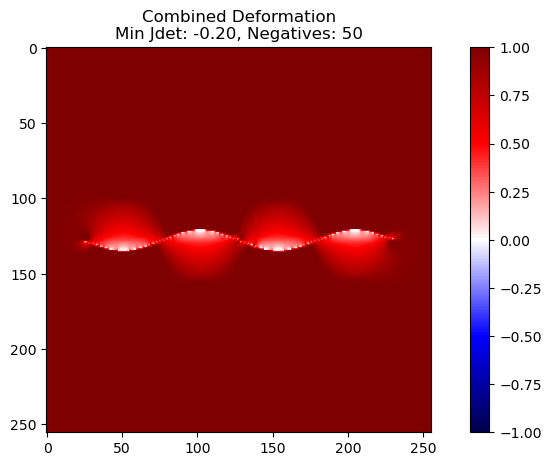

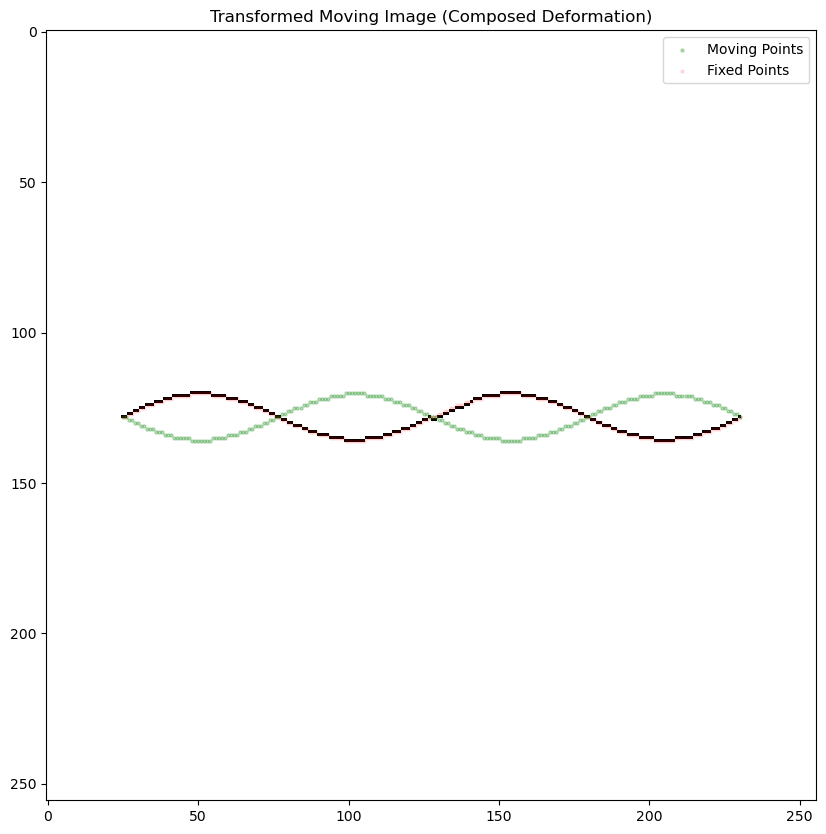

L2 difference between iteration 2 and composed deformation: 0.0
||Ax̂ - b|| for cluster-based deformation: 6.35
L2 error between original deformation and cluster-based deformation: 12.87
Mean error at correspondences: 0.0697148639627674


In [21]:
print("Down indices then up indices")
d_result = cluster_laplacian(helix_wave1, helix_wave2, resolution, [down_indices, up_indices], moving_img)
_, _, _, total_err = reg_utils.compute_error(d_result.resolution, helix_wave1, helix_wave2, d_result.deformation)
print(f"||Ax̂ - b|| for cluster-based deformation: {total_err:.2f}")
print(f"L2 error between original deformation and cluster-based deformation: {np.linalg.norm(d_original.deformation - d_result.deformation):.2f}")
errors = reg_utils.correspondence_error(d_result.deformation, helix_wave1, helix_wave2)
print("Mean error at correspondences:", np.mean(errors))
#print("Max error at correspondences:", np.max(errors))

### Up first

Up indices then down indices


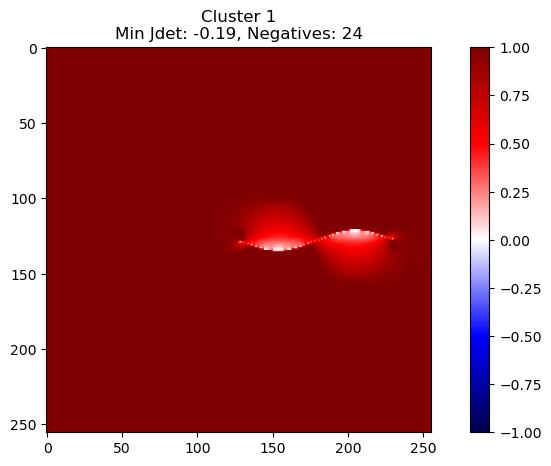

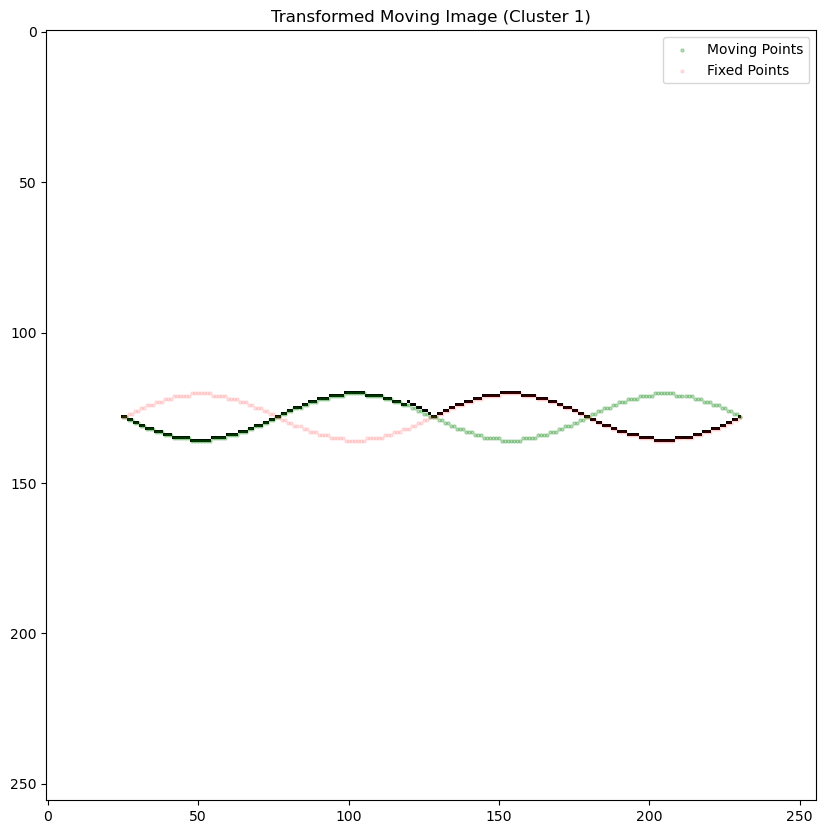

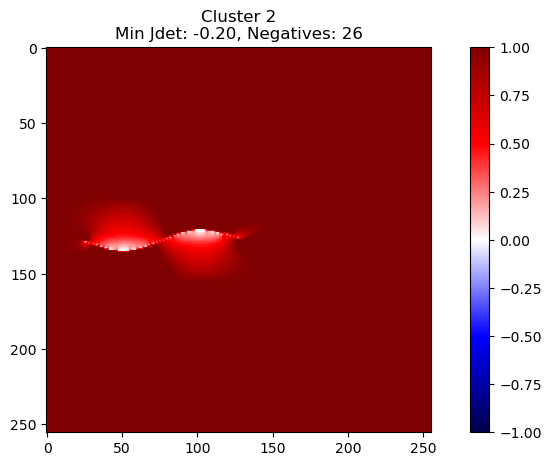

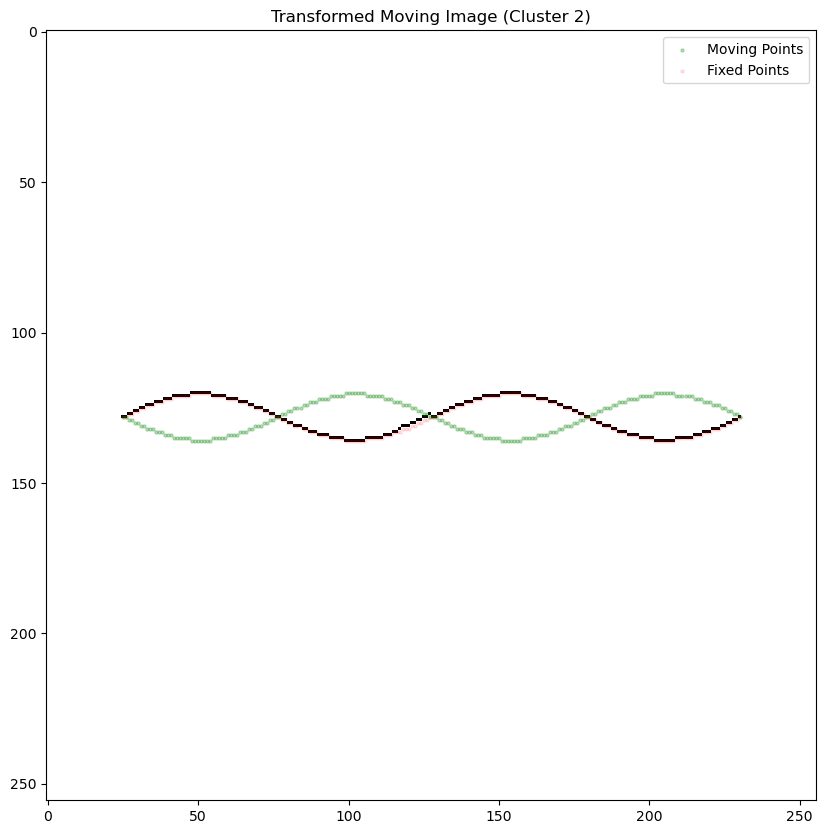

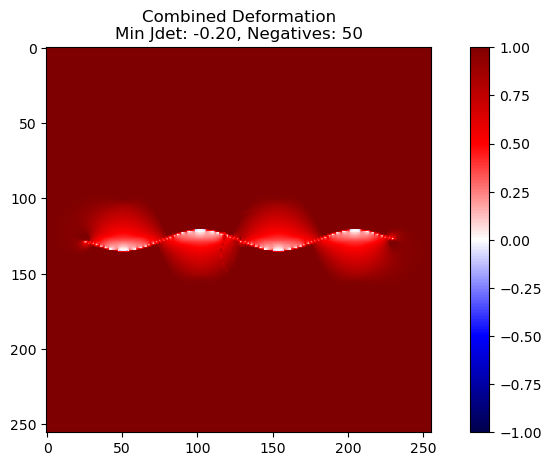

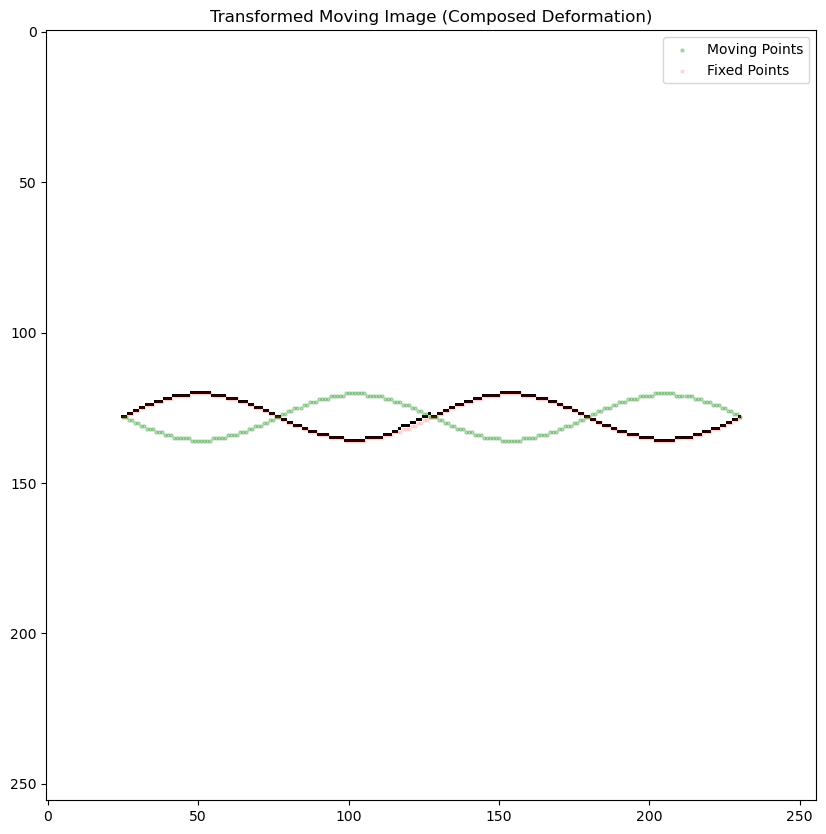

L2 difference between iteration 2 and composed deformation: 0.0
||Ax̂ - b|| for cluster-based deformation: 6.75
L2 error between original deformation and cluster-based deformation: 11.44
Mean error at correspondences: 0.05588040724220143


In [22]:
print("Up indices then down indices")
d_result = cluster_laplacian(helix_wave1, helix_wave2, resolution, [up_indices, down_indices], moving_img)
_, _, _, total_err = reg_utils.compute_error(d_result.resolution, helix_wave1, helix_wave2, d_result.deformation)
print(f"||Ax̂ - b|| for cluster-based deformation: {total_err:.2f}")
print(f"L2 error between original deformation and cluster-based deformation: {np.linalg.norm(d_original.deformation - d_result.deformation):.2f}")
errors = reg_utils.correspondence_error(d_result.deformation, helix_wave1, helix_wave2)
print("Mean error at correspondences:", np.mean(errors))
#print("Max error at correspondences:", np.max(errors))

# Run ANTs

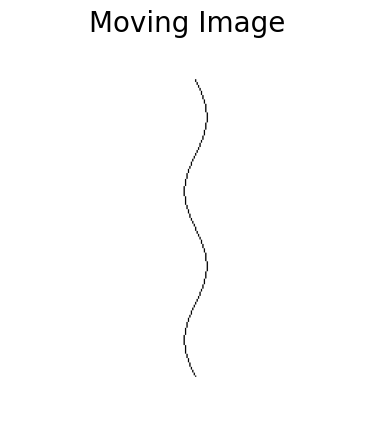

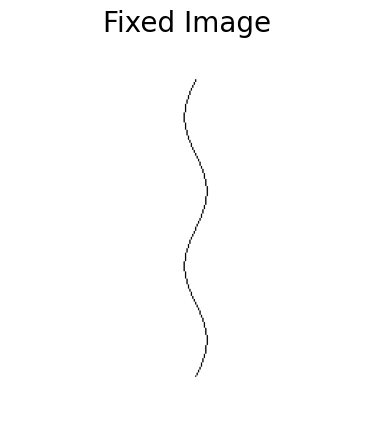

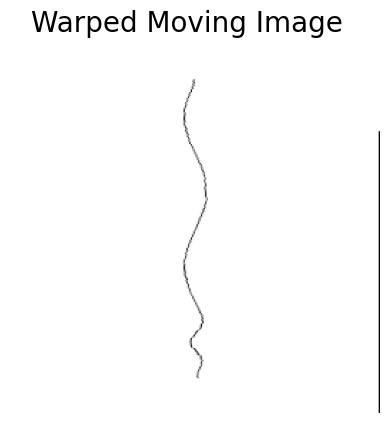

In [23]:
import ants

# Convert numpy arrays to ANTs images
moving_ants = ants.from_numpy(moving_img)
fixed_ants = ants.from_numpy(fixed_img)

# Perform registration (SyN is typical for nonrigid)
reg = ants.registration(
    fixed=fixed_ants,
    moving=moving_ants,
    type_of_transform='SyN'
)

# Get the warped image
warped_moving = reg['warpedmovout']

# Show result
ants.plot(moving_ants, title='Moving Image')
ants.plot(fixed_ants, title='Fixed Image')
ants.plot(warped_moving, title='Warped Moving Image')

# End